<a href="https://colab.research.google.com/github/eadelgadillom/Astronomia_fundamental/blob/main/Bounce_ED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

In [2]:
# Efemerides Tierra
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg

#Transformacion de unidades grado-radián
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')

In [4]:
## Funciones de la Tierra
def Kepler_ellpitic(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime

def find_iota(t, l0, n, t0,):
    return (l0 + n*(t-t0))

def find_f_elliptic(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_elliptic(a, ecc, E):
    return a*(1 - ecc*np.cos(E))

def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)

def find_norm(vector):
    num = np.sqrt(vector[0].value**2 + vector[1].value**2 + vector[2].value**2)
    return num

In [5]:
##___________________________________________________________________________________________________________________________________________________________##
def Kepler_hyperbolic(E, l, ecc):
    f = ecc*np.sinh(E) - E - l
    fprime = ecc*np.cosh(E) - 1
    return f, fprime

In [6]:
## Funciones del cometa
def find_phi_cometa(xyz_vector, r_vector, inclinacion_vector):
    phi_vector = []
    for ii in range (len(xyz_vector)):
        inclinacion = inclinacion_vector
        #z = (xyz_vector[ii][2]*u.au).to('km')
        z = xyz_vector[ii][2]
        #inside = z.value / (r_vector[ii]*np.sin(inclinacion))
        inside = z / (r_vector[ii]*np.sin(inclinacion))
        if inside > 1:
            inside = 1*u.km/u.km
        phi = np.arcsin(inside)
        phi_vector.append(phi)
    return phi_vector

def find_velocidad():
    # Se usa el método del punto medio
    h = tiempos_cometa_inicial[1].utc- tiempos_cometa_inicial[0]
    velocidades_cometa_inicial = [0,0,0]

    for ii in range (3):
        velocidades_cometa_inicial[ii] = (coor_cometa_inicial[2][ii]*u.au - coor_cometa_inicial[0][ii]*u.au) / (2*h)
    return velocidades_cometa_inicial

def find_inclination(xyz_vector, r_vector):
    inclinacion_vector = []
    for ii in range (len(xyz_vector)):
        xy0_vector = [xyz_vector[ii][0], xyz_vector[ii][1], 0]
        dot_product = np.dot(xyz_vector[ii], xy0_vector)
        magnitud_r = r_vector[ii]
        magnitud_rz = np.linalg.norm(xy0_vector)
        inclinacion = np.arccos(dot_product/(magnitud_r*magnitud_rz))
        inclinacion_vector.append(inclinacion)
    return (inclinacion_vector)*u.rad

def find_f_hyperbolic(e, E):
    root_term = np.sqrt( (e+1)/(e-1) )
    right_side = root_term*np.tanh(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_hyperbolic(a, ecc, E):
    return a*(1 - ecc*np.cosh(E))

def find_iota_hyperbolic(t, l0, n, t0,):
    return (n*(t-t0))

In [7]:
## Parámetros temporales de la tierra
N_tiempos = (1*365)
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
tiempos_evolucion = np.linspace(t0, tf, N_tiempos)

## Calculo orbita Tierra
plot_tierra_data = np.zeros((3, N_tiempos))
plot_cometa_data = np.zeros((3, N_tiempos))

for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, l0_tierra, n_tierra, t0)


    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_tierra = root_scalar(Kepler_ellpitic, args=(iota_tierra.value, ecc_tierra), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f_elliptic(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = f_tierra + w_tierra


    ## 5. Hallar r
    r_tierra = find_r_elliptic(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value

In [8]:
#PARÁMETROS DEL COMETA

## Parámetros temporales del cometa
coor_cometa_inicial = [
    [-136.5637561083746,  -58.86174117642695,  0.006477038631585696],
    [-136.52944516728272, -58.8582744676107,   0.006476657161271048],
    [-136.49508281581126, -58.85478559561711,  0.006476273252160792],
    [-123.8254221225029,  -56.75184521313076,  0.006244869528365741],
    [-115.92607005859432, -54.90754850330492,  0.0060419264825281455],
    [-111.38702385389293, -53.724113572894545, 0.0059117034614445335]]

## Parámetros espaciales
coor_cometa_inicial = [
    [-136.5637561083746,  -58.86174117642695,  0.006477038631585696],
    [-136.52944516728272, -58.8582744676107,   0.006476657161271048],
    [-136.49508281581126, -58.85478559561711,  0.006476273252160792],
    [-123.8254221225029,  -56.75184521313076,  0.006244869528365741],
    [-115.92607005859432, -54.90754850330492,  0.0060419264825281455],
    [-111.38702385389293, -53.724113572894545, 0.0059117034614445335]]

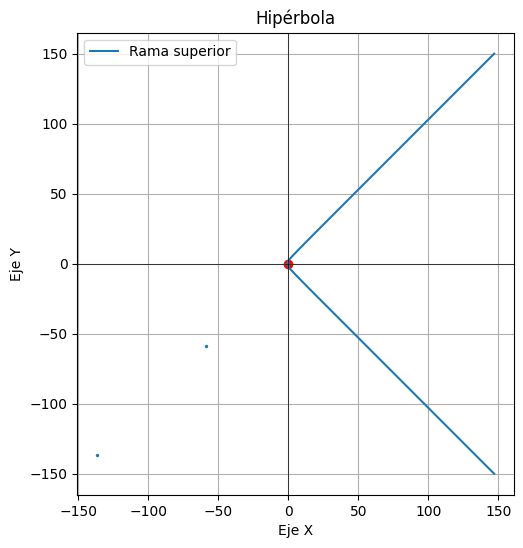

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la hipérbola
excentricidad = 1.5  # Reemplaza esto con tu excentricidad
semieje_mayor = 2.0  # Reemplaza esto con tu distancia del semieje mayor

# Distancia focal
distancia_focal = semieje_mayor * excentricidad

# Crear puntos en el eje x
y = np.linspace(-150, 150, 400)

# Calcular los valores correspondientes en el eje y
x = np.sqrt(semieje_mayor**2 * (excentricidad**2 - 1) + (y)**2) - distancia_focal

# Coordenadas del foco
foco_x = 0
foco_y = 0

# Graficar la hipérbola
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Rama superior')
#plt.plot(x, y2, label='Rama inferior')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Hipérbola')
plt.legend()
plt.grid(True)
plt.scatter([foco_x], [foco_y], color='red', label='Foco')
plt.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], label='Órbita del cometa', s=2)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

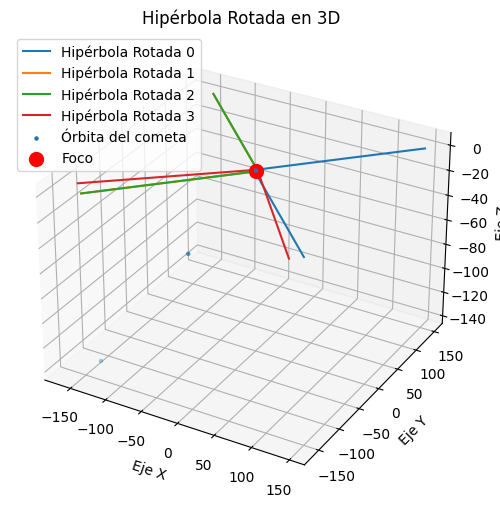

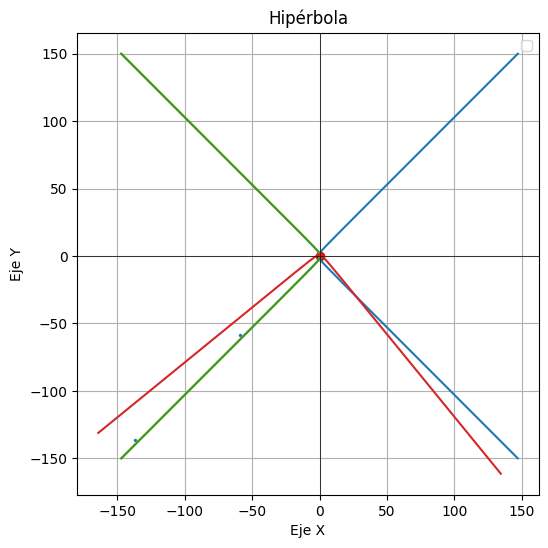

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros de la hipérbola
excentricidad = 1.5  # Reemplaza esto con tu excentricidad
semieje_mayor = 2.0  # Reemplaza esto con tu distancia del semieje mayor

# Distancia focal
distancia_focal = semieje_mayor * excentricidad

# Crear puntos en el eje x
y = np.linspace(-150, 150, 600)
z = np.zeros(600)

# Calcular los valores correspondientes en el eje y
x = np.sqrt(semieje_mayor**2 * (excentricidad**2 - 1) + (y)**2) - distancia_focal

# Coordenadas del foco
foco_y = 0
foco_x = 0

# Ángulo de rotación en grados alrededor del eje z
angulo_rotacion = 0  # Cambia el ángulo de rotación según tus necesidades

# Convertir el ángulo de rotación a radianes
angulo_rad = np.radians(angulo_rotacion)


Omega = -3.14159
iota = -0.00011
omega = -(1.67177 + np.pi)
# Matriz de rotación 3D alrededor del eje z
R_Omega = np.array([[np.cos(Omega), -np.sin(Omega), 0],
              [np.sin(Omega), np.cos(Omega), 0],
              [0, 0, 1]])

R_iota = np.array([[1,0,0],[0, np.cos(iota), -np.sin(iota)],
              [0, np.sin(iota), np.cos(iota)]])

R_omega = np.array([[np.cos(omega), -np.sin(omega), 0],
              [np.sin(omega), np.cos(omega), 0],
              [0, 0, 1]])

# Aplicar la rotación a las coordenadas (x, y)
coordenadas_rotadas_0 = np.vstack((x,y,z))
coordenadas_rotadas_1 = np.dot(R_Omega, coordenadas_rotadas_0)
coordenadas_rotadas_2 = np.dot(R_iota,  coordenadas_rotadas_1)
coordenadas_rotadas_3 = np.dot(R_omega, coordenadas_rotadas_2)

# Graficar la hipérbola rotada en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(coordenadas_rotadas_0[0], coordenadas_rotadas_0[1], coordenadas_rotadas_0[2], label='Hipérbola Rotada 0')
ax.plot(coordenadas_rotadas_1[0], coordenadas_rotadas_1[1], coordenadas_rotadas_1[2], label='Hipérbola Rotada 1')
ax.plot(coordenadas_rotadas_2[0], coordenadas_rotadas_2[1], coordenadas_rotadas_2[2], label='Hipérbola Rotada 2')
ax.plot(coordenadas_rotadas_3[0], coordenadas_rotadas_3[1], coordenadas_rotadas_3[2], label='Hipérbola Rotada 3')
ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=5)
ax.line
ax.scatter([foco_x], [foco_y], [0], color='red', s=100, label='Foco')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
ax.set_title('Hipérbola Rotada en 3D')
ax.legend()
plt.show()

plt.figure(figsize=(8, 6))
#plt.plot(x, y, label='Rama superior')
#plt.plot(x, y2, label='Rama inferior')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Hipérbola')
plt.legend()
plt.grid(True)
plt.scatter([foco_x], [foco_y], color='red', label='Foco')
plt.plot(coordenadas_rotadas_0[0], coordenadas_rotadas_0[1], label='Hipérbola Rotada 0')
plt.plot(coordenadas_rotadas_1[0], coordenadas_rotadas_1[1], label='Hipérbola Rotada 1')
plt.plot(coordenadas_rotadas_2[0], coordenadas_rotadas_2[1], label='Hipérbola Rotada 2')
plt.plot(coordenadas_rotadas_3[0], coordenadas_rotadas_3[1], label='Hipérbola Rotada 3')
plt.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], label='Órbita del cometa', s=2)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()